# Introduction

You probably want to do a similar coastal kelvin and Rossby wave propagation diagnostic for IOD and compare it to the SSH available.

What possible plots could you make?

Your coastal SLA diagrams could be useful.

Do a std of all data at a point versus seasonal plot and compare to SSH form real.

Does this need to be an SLA anomaly?

You should detrend 

regrid sla obs to model ssh since it's coarser

# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py
# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Fns

In [2]:
inpath = '/tigress/GEOCLIM/LRGROUP/Liao/modelres/global_025/'
outpath = '../../data/'

outfn = 'sla_global_processed.nc'


# Get Data

In [3]:
fns = sorted(glob.glob(inpath +'*dynamics2d_monthly*.nc')) # sorted() makes sure the files are sorted in time

# merge all ssh into one file
cnt = 0;
for ff, fn in enumerate(fns[:-1]):
    ds_in = xr.open_dataset(fn)
    
    print('processing: ', fn[-7:-3])
    
    if ff == 0:
        # intialize
        ssh = ds_in.SSH
        lat = ds_in.geolat
        lon = ds_in.geolon
        xh = ds_in.xh
        yh = ds_in.yh
    else:
        # add on current time step along time dimension
        ssh = xr.concat((ssh,ds_in.SSH),dim = 'time')
    
    cnt = cnt + ds_in.time.shape[0]

print('ssh final shape',ssh.shape)

processing:  2003
processing:  2004
processing:  2005
processing:  2006
processing:  2007
processing:  2008
processing:  2009
processing:  2010
processing:  2011
processing:  2012
processing:  2013
processing:  2014
processing:  2015
processing:  2016
processing:  2017
ssh final shape (180, 1080, 1440)


In [5]:
ds_in = xr.open_dataset(fns[0])
ds_in

<xarray.Dataset>
Dimensions:           (nv: 2, time: 12, xh: 1440, xq: 1441, yh: 1080, yq: 1081)
Coordinates:
  * xh                (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yh                (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * time              (time) object 2003-01-16 12:00:00 ... 2003-12-16 12:00:00
  * nv                (nv) float64 1.0 2.0
  * xq                (xq) float64 -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yq                (yq) float64 -80.43 -80.35 -80.27 ... 89.78 89.89 90.0
Data variables:
    geolat            (yh, xh) float32 ...
    geolon            (yh, xh) float32 ...
    geolat_c          (yq, xq) float32 ...
    geolon_c          (yq, xq) float32 ...
    geolat_u          (yh, xq) float32 ...
    geolon_u          (yh, xq) float32 ...
    geolat_v          (yq, xh) float32 ...
    geolon_v          (yq, xh) float32 ...
    SST               (time, yh, xh) float32 ...
    SSS               (time, yh, xh) float32 ..

In [18]:
new_grid = ds_in.geolon[500:500+256,1317:1317+428]
new_grid.shape

(256, 123)

In [14]:
# ds_in.geolon[0,1300:1350]
ds_in.geolon[500,1317:1320]

<xarray.DataArray 'geolon' (xh: 3)>
array([29.375, 29.625, 29.875], dtype=float32)
Coordinates:
  * xh       (xh) float64 29.78 30.03 30.28
    yh       float64 -0.75
Attributes:
    long_name:     Longitude of tracer (T) points
    units:         degrees_east
    cell_methods:  time: point

# Shift Lon 

In [19]:
def shiftlon_glob_MOM6_0_360(lon,lat,invar, plot = False)  
    '''
        Shifts global MOM6 grid and a given variable from -300 to 60 --> 0 to 360 
        so that the Indian Ocean is not cut in half.
        
        Returns shifted numpy arrays of lon, lat, and invar.
        
        Optional boolean plot variable to show domain before and after shift.
       
    '''
    
    # packages
    import numpy as np
    import pyplot.matplotlib as plt

    # make sure all xarray datasets are converted to numpy arrays
    lon = np.array(lon)
    lat = np.array(lat)
    invar = np.array(invar)

    # set -300 to 0 to be positive 60-360
    lon[lon<0] = lon[lon<0]+360
    
    #shift forward by half the length to order data 0-360
    sortind = np.argsort(lon,axis = 1)
    lon = np.take_along_axis(lon, sortind, axis=1)
    lat = np.take_along_axis(lat,sortind, axis=1)

    for tt in range(invar.shape[0]):
        invar[tt,:,:] = np.take_along_axis(invar[tt,:,:],sortind,axis=1)
        
    if plot:
        plt.pcolor(ds.lon,ds.lat,ds.mon_ssh[0,:,:])
        
    return lon,lat,invar

    

In [20]:
# convert to xarray dataset
ds = xr.Dataset(coords={'time': t})

# add variables to dataset
ds['mon_ssh']=xr.DataArray(testssh,dims = ['time','dimy', 'dimx'],
                     coords =[t,np.arange(yh.shape[0]),np.arange(xh.shape[0])])
ds['lat']=xr.DataArray(testlat,dims = ['dimy', 'dimx'],
                     coords =[np.arange(yh.shape[0]),np.arange(xh.shape[0])])
ds['lon']=xr.DataArray(testlon,dims = ['dimy', 'dimx'],
                     coords =[np.arange(yh.shape[0]),np.arange(xh.shape[0])])
# convert to datetime format
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex
ds

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if sys.path[0] == '':


<xarray.Dataset>
Dimensions:  (dimx: 1440, dimy: 1080, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-16T12:00:00 ... 2017-12-16T12:00:00
  * dimy     (dimy) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * dimx     (dimx) int64 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
Data variables:
    mon_ssh  (time, dimy, dimx) float32 nan nan nan ... -0.63636416 -0.635818
    lat      (dimy, dimx) float32 -80.55805 -80.55402 ... 89.93877 89.93877
    lon      (dimy, dimx) float32 0.04642457 0.29471803 ... 301.95428 358.04572

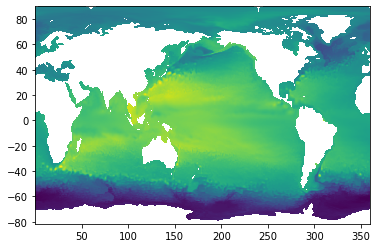

In [13]:
plt.pcolor(ds.lon,ds.lat,ds.mon_ssh[0,:,:])

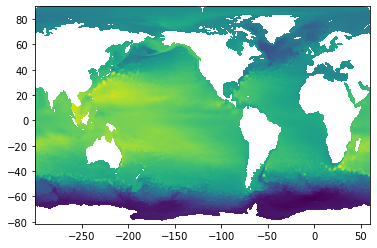

In [14]:
plt.pcolor(lon,lat,ssh[0,:,:])

In [15]:
ds.lat[375:631,0]

<xarray.DataArray 'lat' (dimy: 256)>
array([-30.455408, -30.239664, -30.023445, ...,  29.806755,  30.023445,
        30.239664], dtype=float32)
Coordinates:
  * dimy     (dimy) int64 375 376 377 378 379 380 ... 625 626 627 628 629 630
    dimx     int64 0

In [50]:
newgrid = ds.lon[375:375+256,117:117+428]
newgrid

<xarray.DataArray 'lon' (dimy: 256, dimx: 428)>
array([[ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125],
       [ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125],
       [ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125],
       ...,
       [ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125],
       [ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125],
       [ 29.375,  29.625,  29.875, ..., 135.625, 135.875, 136.125]],
      dtype=float32)
Coordinates:
  * dimy     (dimy) int64 375 376 377 378 379 380 ... 625 626 627 628 629 630
  * dimx     (dimx) int64 117 118 119 120 121 122 ... 539 540 541 542 543 544

In [ ]:
newgrid = ds.lat[500:500+256,117:117+427]

# Subset for Indian Ocean

In [212]:
lat_bounds = [-30.5,30.5]
lon_bounds = [29.375,136.125]


testlat = ds.lat[375:631,118:550]
testlon = ds.lon[375:631,118:550]
testmon_ssh = ds.mon_ssh[:,375:631,118:550]

# lat = np.array(ds.lat)
# latind = (ds.lat >= lat_bounds[0]) & (ds.lat <= lat_bounds[1])
# lonind = (ds.lon >= lon_bounds[0]) & (ds.lon <= lon_bounds[1])
# testlat = ds.lat[latind]
# testlon = ds.lon[latind]
# testssh = ds.mon_ssh[latind]

# # # Subset ------------------------------------------------#
# # lat_slice = slice(lat_bounds[0], lat_bounds[1])
# # lon_slice = slice(lon_bounds[0], lon_bounds[1])

# # ds_out = ds.sel(yh=lat_slice,xh=lon_slice)
# # ds_out

In [213]:
testmon_ssh.shape,testlon.shape

((180, 256, 432), (256, 432))

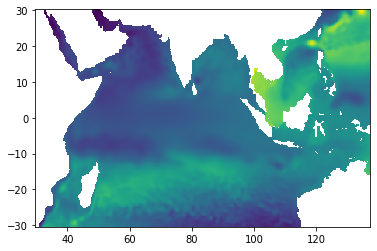

In [214]:
plt.pcolor(testlon,testlat,testmon_ssh[0,:,:])

# Find SLA anomaly relative to total mean

In [5]:

mean_ssh = ds_out.mon_ssh.mean()
mon_sla = ds_out.mon_ssh - mean_ssh

ds_out['mon_sla']=xr.DataArray(mon_sla,dims = ['time','lat', 'lon'],
                     coords =[ssh.time,lat[:,1],lon[1,:]])

# Detrend

In [ ]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = mon_sla.stack(allpoints=['lat','lon'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
mon_sla_slope, mon_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
mon_sla_slope = np.reshape(mon_sla_slope, mon_sla.shape[1:3])
mon_sla_intercept = np.reshape(mon_sla_intercept, mon_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
mon_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
mon_sla_dtrnd = mon_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
mon_sla_dtrnd = mon_sla_dtrnd.where(~np.isnan(mon_sla))

# Plot

In [ ]:
# find global means for comparison
stacked = mon_sla.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
# global_mean.plot()

# find global means for comparison 
stacked = mon_sla_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
# global_mean_dtrnd.plot()
# plt.legend


fig = plt.figure(figsize=(6,3),dpi=200)
plt.plot(global_mean.time,global_mean)
plt.plot(global_mean_dtrnd.time,global_mean_dtrnd, label = 'Detrended')
plt.legend()
plt.title('Indian Ocean Sea Level Anomaly')
plt.ylabel('Sea Level Anomaly ($m$)')
plt.xlabel('Time')

# Monthly Climatology

In [ ]:
# monthly clim
mon_sla_mon_clim = monthly_clim(mon_sla_dtrnd)

# Find Coastlines

In [ ]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_dtrnd[0,:,:]
lat = mask.lat.values
lon = mask.lon.values
xx,yy = np.meshgrid(lon,lat)

In [ ]:
plt.pcolor(mask)

In [ ]:
# # set Gulfs to Nans
# mask = mask.where(~((yy>22) & (xx<57.5)))
# mask = mask.where(~((yy>10) & (xx<51)))

# # AS inlets
# mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
# mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
# mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# # sri lanka are
# mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# # Sumatra area
# mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
# mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
# mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
# mask = mask.where(~((yy>0) & (yy<2.5) & (xx>97) & (xx<98)),1)

# # equator
# mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

# sta_latinds_unord = sta_latinds_unord[46:]
# sta_loninds_unord = sta_loninds_unord[46:]

# sta_latinds_unord = sta_latinds_unord[125:]
# sta_loninds_unord = sta_loninds_unord[125:]

# # AS
# lons_from_sta = lon[sta_loninds_unord]
# lats_from_sta = lat[sta_latinds_unord]

# ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# #BoB
# lons_from_sta = lon[sta_loninds_unord]
# lats_from_sta = lat[sta_latinds_unord]

# ind = ~(lons_from_sta >99)
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-15,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

# Save

In [ ]:
ds_out = xr.Dataset()
                    
                    
ds_out['mon_sla']=xr.DataArray(mon_sla_dtrnd,dims = ['time','lat', 'lon'],
                     coords =[mon_sla_dtrnd.time,mon_sla_dtrnd.lat,mon_sla_dtrnd.lon])

ds_out['mon_sla_mon_clim']=xr.DataArray(mon_sla_mon_clim,dims = ['month','lat', 'lon'],
                     coords =[mon_sla_mon_clim.month,mon_sla_dtrnd.lat,mon_sla_dtrnd.lon])

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outpath + outfn,mode='w',format = "NETCDF4")

ds_out